In [293]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from experiments.evaluation_flow.shared import MODELS
from experiments.plots.util import parse_all_log_files, filter_by_attribute, calc_save_times, all_files_in_dir, \
    use_case_ids, id_use_case_dict, calc_recover_times

In [294]:
ROOT_LOG_DIR = '/Users/nils/Downloads/log-dir'


In [295]:

all_files_parsed = parse_all_log_files(ROOT_LOG_DIR)
baseline_only = filter_by_attribute(all_files_parsed, ('approach', 'param_update_improved'))
baseline_versions = filter_by_attribute(baseline_only, ('snapshot_type', 'fine-tuned'))
baseline_version_food = filter_by_attribute(baseline_versions, ('snapshot_dist', 'outdoor'))

baseline_version_food_server = filter_by_attribute(baseline_version_food, ('location', 'server'))
baseline_version_food_server_0 = filter_by_attribute(baseline_version_food_server, ('run', '1'))

baseline_version_food_node = filter_by_attribute(baseline_version_food, ('location', 'node'))
baseline_version_food_node_0 = filter_by_attribute(baseline_version_food_node, ('run', '1'))

file is broken: /Users/nils/Downloads/log-dir/server--model:googlenet--approach:param_update_improved--snapshot_type:version--snapshot_dist:food--run:0.txt


In [296]:
save_times = calc_save_times(baseline_version_food_server_0, baseline_version_food_node_0)
print(save_times)

{'resnet152': {'U_1': 12.848186285, 'U_2': 2.490724365, 'U_3_1_1': 2.4870168390000003, 'U_3_1_2': 2.534706006, 'U_3_1_3': 2.613695974, 'U_3_1_4': 2.6438623590000003, 'U_3_2_1': 2.7528206230000003, 'U_3_2_2': 2.819581732, 'U_3_2_3': 2.8785699150000004, 'U_3_2_4': 2.939487707}, 'resnet50': {'U_1': 12.130915028, 'U_2': 2.0581765880000003, 'U_3_1_1': 2.019961925, 'U_3_1_2': 2.1299736410000003, 'U_3_1_3': 2.117488045, 'U_3_1_4': 2.154026662, 'U_3_2_1': 2.245583282, 'U_3_2_2': 2.25952381, 'U_3_2_3': 2.271478273, 'U_3_2_4': 2.280608172}, 'resnet18': {'U_1': 11.896986428, 'U_2': 1.804420048, 'U_3_1_1': 1.790066865, 'U_3_1_2': 1.8484749640000002, 'U_3_1_3': 1.80506673, 'U_3_1_4': 1.892533663, 'U_3_2_1': 1.9495099390000001, 'U_3_2_2': 1.909747397, 'U_3_2_3': 1.959538172, 'U_3_2_4': 1.9779360970000002}, 'mobilenet': {'U_1': 11.771508329000001, 'U_2': 1.713192878, 'U_3_1_1': 1.6627479170000001, 'U_3_1_2': 1.6462201570000001, 'U_3_1_3': 1.7009605710000002, 'U_3_1_4': 1.7057547830000002, 'U_3_2_1': 

In [297]:
def rearrange_u2(use_cases):
    use_cases.sort()
    # remove U_2
    u2 = use_cases.pop(1)
    num_cases = len(use_cases)
    new_u2_pos = int((num_cases - 1) / 2) + 1
    use_cases.insert(new_u2_pos, u2)
    return use_cases


def plot_save_time_one_model(save_times, save_path=None):
    # TODO include U1 as soon as be have the new results
    use_cases = rearrange_u2(list(save_times.keys()))[1:]

    plt.rc('font', size=12)
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    times = [save_times[k] for k in use_cases]
    ax.bar(use_cases, times)
    ax.set_ylabel('Save time in seconds')
    ax.set_xlabel('Use case description')
    plt.xticks(rotation=45)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    plt.show()

    # TODO save plot

    print(use_cases)

In [298]:
def plot_recover_time_one_model(save_times, save_path=None):
    use_cases = rearrange_u2(list(save_times.keys()))

    plt.rc('font', size=12)
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    times = [save_times[k] for k in use_cases]
    ax.bar(use_cases, times)
    ax.set_ylabel('Recover time in seconds')
    ax.set_xlabel('Use case description')
    plt.xticks(rotation=45)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

    plt.show()

    # TODO save plot

    print(use_cases)

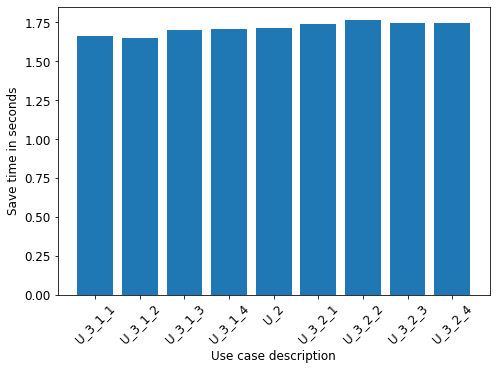

['U_3_1_1', 'U_3_1_2', 'U_3_1_3', 'U_3_1_4', 'U_2', 'U_3_2_1', 'U_3_2_2', 'U_3_2_3', 'U_3_2_4']


In [299]:
plot_save_time_one_model(save_times['mobilenet'], './pdfs/mobilenet.pdf')

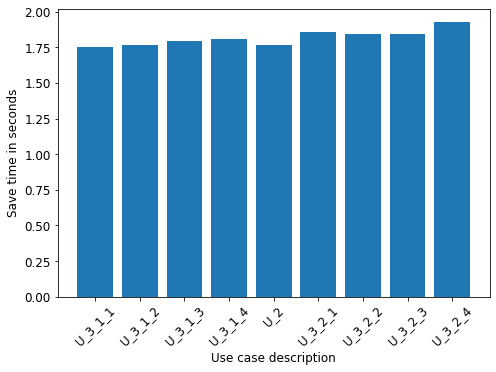

['U_3_1_1', 'U_3_1_2', 'U_3_1_3', 'U_3_1_4', 'U_2', 'U_3_2_1', 'U_3_2_2', 'U_3_2_3', 'U_3_2_4']


In [300]:
plot_save_time_one_model(save_times['googlenet'])

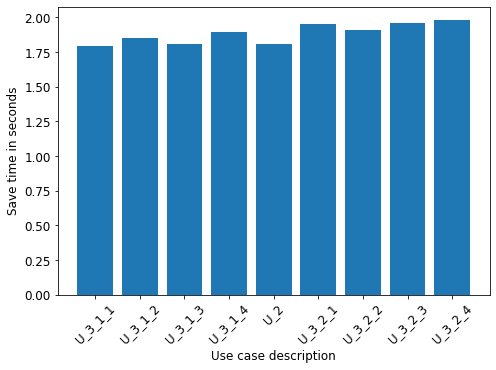

['U_3_1_1', 'U_3_1_2', 'U_3_1_3', 'U_3_1_4', 'U_2', 'U_3_2_1', 'U_3_2_2', 'U_3_2_3', 'U_3_2_4']


In [301]:
plot_save_time_one_model(save_times['resnet18'])

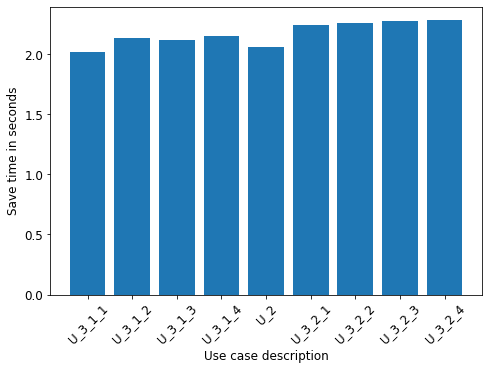

['U_3_1_1', 'U_3_1_2', 'U_3_1_3', 'U_3_1_4', 'U_2', 'U_3_2_1', 'U_3_2_2', 'U_3_2_3', 'U_3_2_4']


In [302]:
plot_save_time_one_model(save_times['resnet50'])

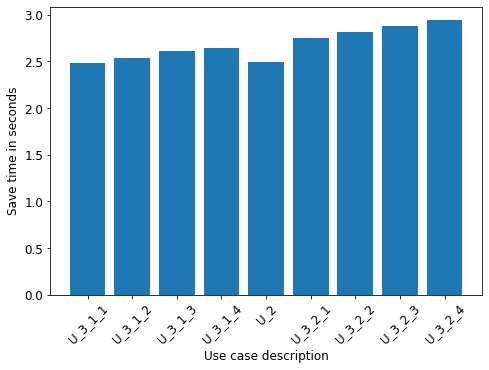

['U_3_1_1', 'U_3_1_2', 'U_3_1_3', 'U_3_1_4', 'U_2', 'U_3_2_1', 'U_3_2_2', 'U_3_2_3', 'U_3_2_4']


In [303]:
plot_save_time_one_model(save_times['resnet152'])

In [304]:
all_files = all_files_in_dir(ROOT_LOG_DIR)
id_to_use_case= [id_use_case_dict(log_file) for log_file in all_files]
id_use_case_mapping = {}
for d in id_to_use_case:
    id_use_case_mapping.update(d)
print(id_use_case_mapping)


{'60c622b4dfee2b0edc6be205': 'U_1', '60c622cef6736038e0301a0a': 'U_3_1_1', '60c622d0f6736038e0301a0c': 'U_3_1_2', '60c622d3f6736038e0301a0e': 'U_3_1_3', '60c622d5f6736038e0301a10': 'U_3_1_4', '60c622dadfee2b0edc6be208': 'U_2', '60c622ddf6736038e0301a12': 'U_3_2_1', '60c622dff6736038e0301a14': 'U_3_2_2', '60c622e2f6736038e0301a16': 'U_3_2_3', '60c622e4f6736038e0301a18': 'U_3_2_4', '60c61a692ea5e88658c8f0ee': 'U_1', '60c61a8326e05abfafa4c8d6': 'U_3_1_1', '60c61a8526e05abfafa4c8d8': 'U_3_1_2', '60c61a8726e05abfafa4c8da': 'U_3_1_3', '60c61a8a26e05abfafa4c8dc': 'U_3_1_4', '60c61a8c2ea5e88658c8f0f1': 'U_2', '60c61a9126e05abfafa4c8de': 'U_3_2_1', '60c61a9326e05abfafa4c8e0': 'U_3_2_2', '60c61a9626e05abfafa4c8e2': 'U_3_2_3', '60c61a9826e05abfafa4c8e4': 'U_3_2_4', '60c619ee1384ad6dfdb65193': 'U_1', '60c61a07b88a333a49841a6f': 'U_3_1_1', '60c61a0ab88a333a49841a71': 'U_3_1_2', '60c61a0cb88a333a49841a73': 'U_3_1_3', '60c61a0fb88a333a49841a75': 'U_3_1_4', '60c61a111384ad6dfdb65196': 'U_2', '60c61a16

In [305]:
rec_times = calc_recover_times(baseline_version_food_server_0)
print(rec_times)

{'resnet152': {'U_1': 3.9513479750000005, 'U_3_1_1': 4.186774923000001, 'U_3_1_2': 4.893510558, 'U_3_1_3': 5.254300286, 'U_3_1_4': 5.623686738, 'U_2': 4.152420792, 'U_3_2_1': 4.8556825980000005, 'U_3_2_2': 5.231906288, 'U_3_2_3': 5.884970733, 'U_3_2_4': 6.304482866000001}, 'resnet50': {'U_1': 2.612313079, 'U_3_1_1': 2.7129113630000004, 'U_3_1_2': 2.843289303, 'U_3_1_3': 3.095214984, 'U_3_1_4': 3.3117008340000003, 'U_2': 2.7086457850000003, 'U_3_2_1': 2.881853566, 'U_3_2_2': 3.105902159, 'U_3_2_3': 3.2528986050000004, 'U_3_2_4': 3.4196320090000003}, 'resnet18': {'U_1': 2.038590611, 'U_3_1_1': 2.106919737, 'U_3_1_2': 2.193706561, 'U_3_1_3': 2.280907786, 'U_3_1_4': 2.341979257, 'U_2': 2.060010805, 'U_3_2_1': 2.172793537, 'U_3_2_2': 2.250046354, 'U_3_2_3': 2.33632405, 'U_3_2_4': 2.4380882390000003}, 'mobilenet': {'U_1': 1.810652909, 'U_3_1_1': 1.853290287, 'U_3_1_2': 1.939068401, 'U_3_1_3': 1.991784425, 'U_3_1_4': 2.0127803660000003, 'U_2': 1.8179204210000002, 'U_3_2_1': 1.899929149, 'U_3_

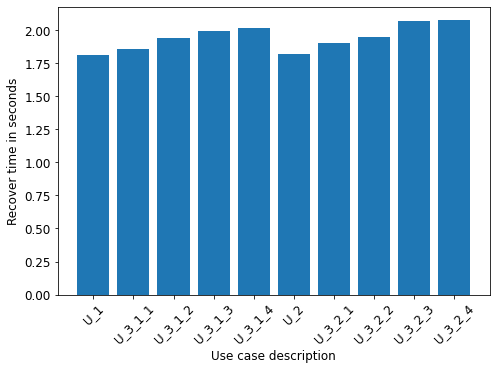

['U_1', 'U_3_1_1', 'U_3_1_2', 'U_3_1_3', 'U_3_1_4', 'U_2', 'U_3_2_1', 'U_3_2_2', 'U_3_2_3', 'U_3_2_4']


In [306]:
plot_recover_time_one_model(rec_times['mobilenet'])

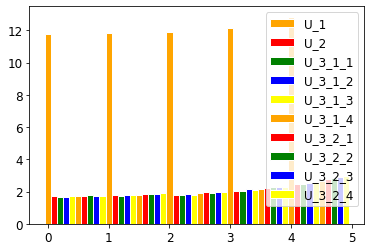

In [307]:

# set width of bars
barWidth = 0.1

bars = {}
for m in MODELS:
    times = save_times[m]
    for use_case, time in times.items():
        if use_case in bars:
            bars[use_case].append(time)
        else:
            bars[use_case] = [time]

# Set position of bar on X axis
# l = len(bars[U_1])
# print(l)
# positions = [np.arange(l)]
# for i in range(1, len(bars)):
#     prev_positions = positions[-1]
#     positions.append(prev_positions)

r1 = np.arange(5)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
positions = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10]

colors = ['orange', 'red', 'green', 'blue', 'yellow', 'orange', 'red', 'green', 'blue', 'yellow']

for position, bar, color, label in zip(positions, list(bars.values())[:], colors, list(bars.keys())[:]):
    plt.bar(position, bar, color=color, width=barWidth, edgecolor='white', label=label)

# # Add xticks on the middle of the group bars
# plt.xlabel('group', fontweight='bold')
# plt.xticks([r + barWidth for r in range(len(bars1))], ['A', 'B', 'C', 'D', 'E'])

# Create legend & Show graphic
plt.legend()
plt.show()

In [308]:
meta, events = baseline_version_food_server_0[0]
e_u1 = events[0]
e_u2 = events[5]
print(e_u1)
print(e_u2)



U_1: 12.8481862850s 
save_model -- all: 10.9543617320s 
	_save_full_model -- all: 10.9129115280s 
		_save_full_model -- pickle_weights: 0.2945753100s 
		_save_full_model -- _get_weights_hash_info: 0.3323593150s 
		_save_full_model -- persist_model_info: 10.2841915950s 
			persist -- schema_obj(model_info): 10.2834774710s 
				persist -- schema_obj(recover_info): 10.2630877300s 
					mmlib_file_pers -- save_file: 0.0254542320s 
					mmlib_file_pers -- save_file: 0.2151073280s 
					persist -- schema_obj(environment): 10.0197265610s 
						mmlib_dict_pers -- save_dict -- collection(environment): 10.0194790800s 
					mmlib_dict_pers -- save_dict -- collection(recover_info): 0.0024953190s 
				mmlib_dict_pers -- save_dict -- collection(model_info): 0.0161669870s 

U_2: 2.4907243650s 
save_model -- all: 0.4414116780s 
	_save_updated_model -- all: 0.4395781020s 
		_save_updated_model -- get_weights_hash_info: 0.3446304500s 
		_save_updated_model -- generate_weights_update: 0.0389155620s 
			

In [309]:
meta, events = extract_event_and_and_meta('/Users/nils/Downloads/test-env-log.txt')

NameError: name 'extract_event_and_and_meta' is not defined

In [ ]:
for e in events:
    print(e)